In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

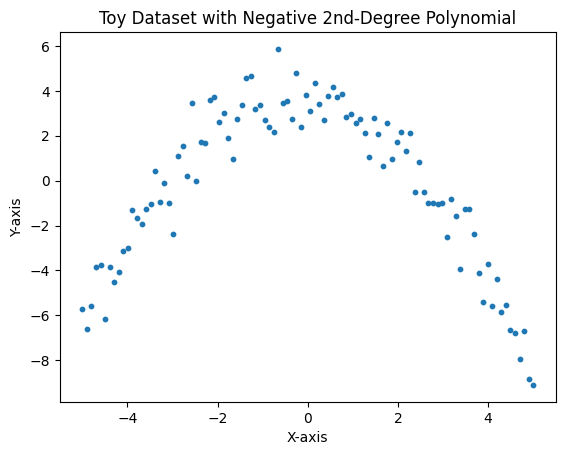

In [8]:
# Generate synthetic 2D data like one moon
np.random.seed(0)
n_samples = 500
# Define the coefficients of the negative 2nd-degree polynomial equation
a = -0.5
b = -0.2
c = 4
# Generate x-values
x = np.linspace(-5, 5, 100)
# Calculate y-values using the polynomial equation
y = a * x**2 + b * x + c
# Add some random noise to the y-values
noise_scale = 1.0
y_noisy = y + noise_scale * np.random.randn(len(x))
# Create the toy dataset
data = np.vstack((x, y_noisy)).T
# Plot the toy dataset
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.title("Toy Dataset with Negative 2nd-Degree Polynomial")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [ ]:
class ImageFlow(pl.LightningModule):
    
    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images. 
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])                             
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)
        
        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)
        
        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()
        
        self.log('test_bpd', bpd)
        
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter, 
        # but should be part of the modules state.
        self.register_buffer('mask', mask)
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows. 
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
            
        return z, ldj



In [ ]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    scaling_factors = [0.5, 1, 2]
    sns.set()
    fig, ax = plt.subplots(1, 3, figsize=(12,3))
    for i, scale in enumerate(scaling_factors):
        y = torch.tanh(x / scale) * scale
        ax[i].plot(x.numpy(), y.numpy())
        ax[i].set_title("Scaling factor: " + str(scale))
        ax[i].set_ylim(-3, 3)
    plt.subplots_adjust(wspace=0.4)
    sns.reset_orig()
    plt.show()

In [12]:
in_features = 2
# Define a simple affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, in_features, hidden_dim=16):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(in_features // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_features // 2),
            nn.Tanh()
        )
        self.translation_net = nn.Sequential(
            nn.Linear(in_features // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_features // 2)
        )

    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        if not reverse:
            scale = self.scale_net(x1)
            translation = self.translation_net(x1)
            y1 = x1
            y2 = x2 * scale.exp() + translation
        else:
            scale = self.scale_net(x1)
            translation = self.translation_net(x1)
            y1 = x1
            y2 = (x2 - translation) / scale.exp()
        return torch.cat([y1, y2], dim=1)

# Define a normalizing flow model
class NormalizingFlow(nn.Module):
    def __init__(self, num_coupling_layers, in_features):
        super(NormalizingFlow, self).__init__()
        self.num_coupling_layers = num_coupling_layers
        self.coupling_layers = nn.ModuleList([
            AffineCoupling(in_features) for _ in range(num_coupling_layers)
        ])

    def forward(self, x, reverse=False):
        log_det_Jacobian = 0
        if not reverse:
            for coupling_layer in self.coupling_layers:
                x = coupling_layer(x)
                log_det_Jacobian += torch.sum(coupling_layer.scale_net(x[:, :in_features // 2]), dim=1)
        else:
            for coupling_layer in reversed(self.coupling_layers):
                x = coupling_layer(x, reverse=True)
        return x, log_det_Jacobian

############
# Define a function to visualize data transformation through the model
def visualize_transformation(model, data):
    # Convert data to tensor
    data = torch.FloatTensor(data)

    # Transform data through the model
    transformed_data, _ = model(data)

    return transformed_data.detach().numpy()

In [13]:
# Initialize the normalizing flow model with Kaiming He initialization for better convergence
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

num_coupling_layers = 20
in_features = 2
flow_model = NormalizingFlow(num_coupling_layers, in_features)
flow_model.apply(weights_init)  # Initialize weights

# Training
num_epochs = 1000
lr = 0.001
weight_decay = 1e-5  # L2 regularization strength to prevent overfitting
optimizer = optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    z, log_det_Jacobian = flow_model(torch.FloatTensor(data))
    loss = -torch.mean(log_det_Jacobian)  # Negative log-likelihood
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

# Generate samples from the trained model
with torch.no_grad():
    z_samples = torch.randn(n_samples, in_features)
    x_samples, _ = flow_model(z_samples, reverse=True)
    x_samples = x_samples.numpy()

Epoch [0/1000], Loss: 0.5531825423240662
Epoch [100/1000], Loss: -13.804361343383789
Epoch [200/1000], Loss: -18.851306915283203
Epoch [300/1000], Loss: -19.357698440551758
Epoch [400/1000], Loss: -19.588134765625
Epoch [500/1000], Loss: -19.716310501098633
Epoch [600/1000], Loss: -19.795568466186523
Epoch [700/1000], Loss: -19.847379684448242
Epoch [800/1000], Loss: -19.882976531982422
Epoch [900/1000], Loss: -19.90802574157715


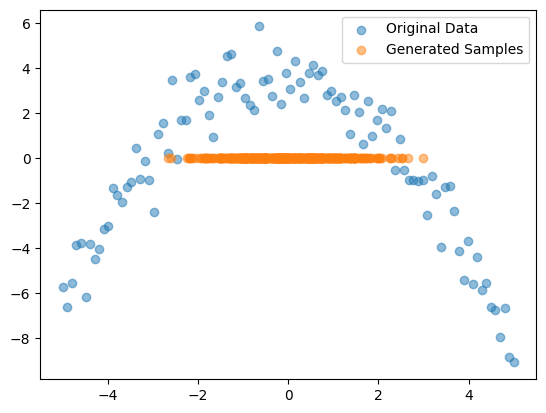

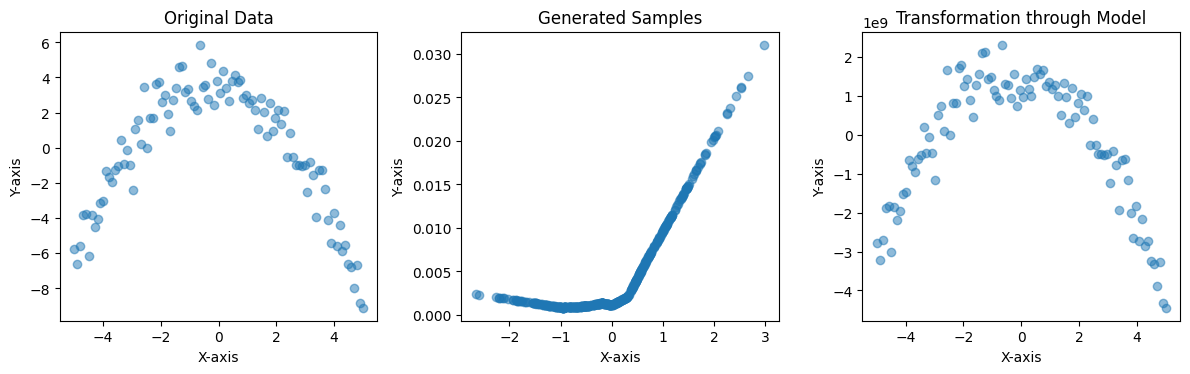

In [11]:
# Plot the original data and generated samples
plt.scatter(data[:, 0], data[:, 1], label='Original Data', alpha=0.5)
plt.scatter(x_samples[:, 0], x_samples[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()


# Visualize the original data, generated samples, and the transformation
plt.figure(figsize=(12, 4))

# Plot original data
plt.subplot(131)
plt.scatter(data[:, 0], data[:, 1], label='Original Data', alpha=0.5)
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Plot generated samples
plt.subplot(132)
plt.scatter(x_samples[:, 0], x_samples[:, 1], label='Generated Samples', alpha=0.5)
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Plot transformation through the model
transformed_data = visualize_transformation(flow_model, data)
plt.subplot(133)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], label='Transformed Data', alpha=0.5)
plt.title("Transformation through Model")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()
